# Forced Alignment with Wav2Vec
文字和音频的严格对齐任务
具体步骤：
1. 从音频讯号中逐帧进行label的概率生成
2. 生成网格矩阵，表示标签对齐的概率
3. 从网格中找到最可能的路径

In [1]:
import os
from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cuda:1


In [2]:
data_root_path = 'audio_study/data/study_data/'

In [3]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = data_root_path + "speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [4]:
# 导入模型
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
labels

('-',
 '|',
 'E',
 'T',
 'A',
 'O',
 'N',
 'I',
 'H',
 'S',
 'R',
 'D',
 'L',
 'U',
 'M',
 'W',
 'C',
 'F',
 'G',
 'Y',
 'P',
 'B',
 'V',
 'K',
 "'",
 'X',
 'J',
 'Q',
 'Z')

In [5]:
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE) # 导入音频
    emissions, _ = model(waveform.to(device))  # 进行推理[batch, time frame, classes]
    emissions = torch.log_softmax(emissions, dim=-1) # 将score变为概率分布

In [6]:
emissions.shape

torch.Size([1, 169, 29])

In [9]:
emissions = emissions[0]

In [10]:
emissions.shape

torch.Size([169, 29])

In [16]:
emissions = emissions.cpu().detach()

In [11]:
# 生成转换概率矩阵
# 转换概率矩阵是一个2D矩阵 横轴纵轴分别是时间time和文字label
transcript = "I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT"
dictionary = {c: i for i, c in enumerate(labels)}
dictionary

{'-': 0,
 '|': 1,
 'E': 2,
 'T': 3,
 'A': 4,
 'O': 5,
 'N': 6,
 'I': 7,
 'H': 8,
 'S': 9,
 'R': 10,
 'D': 11,
 'L': 12,
 'U': 13,
 'M': 14,
 'W': 15,
 'C': 16,
 'F': 17,
 'G': 18,
 'Y': 19,
 'P': 20,
 'B': 21,
 'V': 22,
 'K': 23,
 "'": 24,
 'X': 25,
 'J': 26,
 'Q': 27,
 'Z': 28}

In [12]:
tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))
# 一个从label到int的对应
print(tokens)

[('I', 7), ('|', 1), ('H', 8), ('A', 4), ('D', 11), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('O', 5), ('S', 9), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('B', 21), ('E', 2), ('S', 9), ('I', 7), ('D', 11), ('E', 2), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('O', 5), ('M', 14), ('E', 2), ('N', 6), ('T', 3)]
[7, 1, 8, 4, 11, 1, 3, 8, 4, 3, 1, 16, 13, 10, 7, 5, 9, 7, 3, 19, 1, 21, 2, 9, 7, 11, 2, 1, 14, 2, 1, 4, 3, 1, 3, 8, 7, 9, 1, 14, 5, 14, 2, 6, 3]


In [17]:
def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0) # 时间维度上有time frame个信息
    num_tokens = len(tokens) # tokens可选文本的信息

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf")) # 转换矩阵的维度是[time frame +1, num_tokens + 1]
                                                                         # 所以转换矩阵就是在每个时间维度上，从上一时刻的token和这一时刻的音频信息 进行这一时刻token概率预测的过程，对于每一个t都对应了所有的token个概率
    #[time frame +1]的原因是有一个起始位置 翻译从第二个位置即下标1开始
    #[num_tokens + 1]的原因是有一个SOS token的位置
    trellis[:, 0] = 0               # 第一个token是<sos> 0 或者说是None
    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id], # 上一步取每个label的token信息 trellis[t,1:] 加上CTC语义识别为None的概率和 emission[t, blank_id]
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens], # CTC在t时刻对应上一个前一个token的概率 CTC在t时刻取每个新tokens的概率 emission[t, tokens]
        )
    return trellis


trellis = get_trellis(emissions, tokens)
# 得到的就是在每个时间片t时刻转移到下一个token的概率

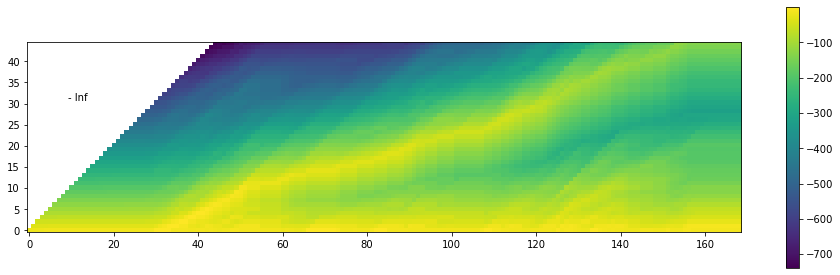

In [18]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()
# 可以看到对角线有一个明显的曲线

In [19]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1 # 最后一个token的index
    t_start = torch.argmax(trellis[:, j]).item() # trellis[:, j]是最后一个token在所有时间片的概率 argmax就得到了推理出最后一个token时的时间片index

    path = []
    for t in range(t_start, 0, -1): # 从最后一个时间片迭代回起始时刻
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]] # 注意这里是tokens[j-1]代表了第j个token的概率

        # 进行回溯，判断当时得到trellis[t, j]时，是从stayed过来的还是从changed过来的
        # stayed的概率就是上一时刻还是j的概率 加上emission推理为None的概率
        # changed的概率就是上一时刻j-1的概率 加上emission推理为j的概率

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item() # 如果changed概率大 那么得到emission的概率 否则是0
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]

path = backtrack(trellis, emissions, tokens)
print(path)

[Point(token_index=0, time_index=30, score=0.9999842643737793), Point(token_index=0, time_index=31, score=0.9844332933425903), Point(token_index=0, time_index=32, score=0.9999706745147705), Point(token_index=0, time_index=33, score=0.15372951328754425), Point(token_index=1, time_index=34, score=0.9999173879623413), Point(token_index=1, time_index=35, score=0.607542097568512), Point(token_index=2, time_index=36, score=0.9997720122337341), Point(token_index=2, time_index=37, score=0.9997082352638245), Point(token_index=3, time_index=38, score=0.9999358654022217), Point(token_index=3, time_index=39, score=0.9861365556716919), Point(token_index=4, time_index=40, score=0.9241234660148621), Point(token_index=4, time_index=41, score=0.9259020686149597), Point(token_index=4, time_index=42, score=0.015581986866891384), Point(token_index=5, time_index=43, score=0.99983811378479), Point(token_index=6, time_index=44, score=0.9988446235656738), Point(token_index=6, time_index=45, score=0.1016075909

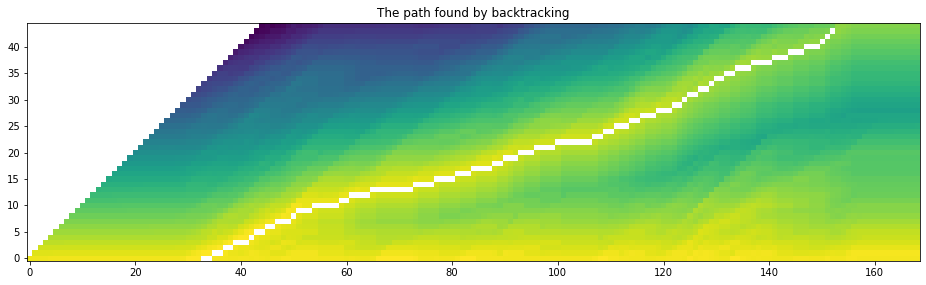

In [20]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()